In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, 
                             f1_score, make_scorer, roc_auc_score, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
import time

###  Gelişmiş Ön İşleme ve Lojistik Regresyon Kurulumu

Bu bölümde, özellikle **dengesiz veri setleri (imbalanced datasets)** ile çalışmak üzere özelleştirilmiş kütüphaneler yüklenmektedir. Standart işlemlere ek olarak:

*   **SMOTE & Pipeline:** Veri dengesizliğini gidermek için `SMOTE` ve bu işlemi sızıntı (data leakage) olmadan uygulamak için `imbpipeline` kullanılmaktadır.
*   **Boyut İndirgeme:** Değişken sayısını optimize etmek için `PCA` (Temel Bileşen Analizi) eklenmiştir.
*   **Modelleme:** Temel referans (baseline) oluşturmak için `DummyClassifier` ve doğrusal modelleme için `LogisticRegression` seçilmiştir.
*   **Optimizasyon:** Hiperparametre araması için `GridSearchCV` dahildir.

In [2]:
# ======================================================================================
# --- BÖLÜM 0: VERİ YÜKLEME ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 0: VERİ YÜKLEME ###")
print("############################################################\n")

df = pd.read_csv('US_Accidents_March23.csv') 
print(f"Veri Seti Boyutu: {df.shape}")

print("\n--- Orijinal Sınıf Dağılımı ---")
print(df['Severity'].value_counts())
print("\n--- Yüzdesel Dağılım ---")
print(df['Severity'].value_counts(normalize=True))
print("\n\n")



############################################################
### BÖLÜM 0: VERİ YÜKLEME ###
############################################################

Veri Seti Boyutu: (7728394, 46)

--- Orijinal Sınıf Dağılımı ---
Severity
2    6156981
3    1299337
4     204710
1      67366
Name: count, dtype: int64

--- Yüzdesel Dağılım ---
Severity
2    0.796670
3    0.168125
4    0.026488
1    0.008717
Name: proportion, dtype: float64





###  Veri Setinin Yüklenmesi

Proje veri seti Pandas kullanılarak okunmaktadır. Yükleme işleminin hemen ardından, veri setinin genel boyutlarını ve hedef değişkenimiz olan **'Severity' (Kaza Şiddeti)** sütununun dağılımını ekrana yazdırıyoruz. Bu çıktı, modelleme stratejimizi (örneğin SMOTE kullanım gerekliliğini) belirlememize yardımcı olacaktır.

In [3]:
# ======================================================================================
# --- BÖLÜM 1: STRATİFİED DENGELİ ÖRNEKLEME ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 1: DENGELİ ÖRNEKLEME STRATEJİSİ ###")
print("############################################################\n")

print("--- Stratified Dengeli Örnekleme Uygulanıyor ---")

sample_sizes = {
    1: 50000,
    2: 800000,
    3: 400000,
    4: 100000
}

dfs = []
for severity, size in sample_sizes.items():
    df_class = df[df['Severity'] == severity]
    
    if len(df_class) < size:
        print(f"  Severity {severity}: {len(df_class)} örnek (hepsi alınıyor)")
        dfs.append(df_class)
    else:
        print(f"  Severity {severity}: {size} örnek (rastgele seçildi)")
        dfs.append(df_class.sample(n=size, random_state=42))

df_sample = pd.concat(dfs, ignore_index=True)
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

del df

print(f"\n--- Dengeli Örneklem Sonrası Toplam: {len(df_sample)} ---")
print(df_sample['Severity'].value_counts())
print("\n--- Yeni Yüzdesel Dağılım ---")
print(df_sample['Severity'].value_counts(normalize=True))

print("\n--- Veri, Eğitim ve Test Setlerine Bölünüyor ---")
X = df_sample.drop('Severity', axis=1)
y = df_sample['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nEğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")
print("\n\n")

############################################################
### BÖLÜM 1: DENGELİ ÖRNEKLEME STRATEJİSİ ###
############################################################

--- Stratified Dengeli Örnekleme Uygulanıyor ---
  Severity 1: 50000 örnek (rastgele seçildi)
  Severity 2: 800000 örnek (rastgele seçildi)
  Severity 3: 400000 örnek (rastgele seçildi)
  Severity 4: 100000 örnek (rastgele seçildi)

--- Dengeli Örneklem Sonrası Toplam: 1350000 ---
Severity
2    800000
3    400000
4    100000
1     50000
Name: count, dtype: int64

--- Yeni Yüzdesel Dağılım ---
Severity
2    0.592593
3    0.296296
4    0.074074
1    0.037037
Name: proportion, dtype: float64

--- Veri, Eğitim ve Test Setlerine Bölünüyor ---

Eğitim seti boyutu: (1080000, 45)
Test seti boyutu: (270000, 45)





###  Örnekleme ve Eğitim Seti Hazırlığı

Bu blokta aşağıdaki adımlar sırasıyla uygulanır:

1.  **Kota Belirleme:** `sample_sizes` sözlüğü ile her sınıftan kaç adet veri alınacağı belirlenir.
2.  **Koşullu Seçim:** Döngü içerisinde; eğer bir sınıfın veri sayısı hedeften azsa **tamamı**, fazlaysa **rastgele seçilen bir kısmı** alınır.
3.  **Birleştirme ve Karıştırma:** Seçilen veriler birleştirilir (`concat`) ve sıralamanın model öğrenimini etkilememesi için karıştırılır (`shuffle`).
4.  **Train/Test Split:** Veri seti özellikler (`X`) ve hedef değişken (`y`) olarak ayrılır. Ardından modelin görmediği verilerle test edilebilmesi için `train_test_split` uygulanır.

In [4]:
# ======================================================================================
# --- BÖLÜM 2: ÖZELLİK YARATMA ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 2: ÖZELLİK YARATMA ###")
print("############################################################\n")

def feature_creation_pipeline(df_input):
    df = df_input.copy()
    
    print("... Zamansal özellikler oluşturuluyor...")
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
    df['Hour'] = df['Start_Time'].dt.hour
    df['Month'] = df['Start_Time'].dt.month
    df['DayOfWeek'] = df['Start_Time'].dt.dayofweek
    df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)
    df['Is_Rush_Hour'] = ((df['Is_Weekend'] == 0) & (df['Hour'].isin([7, 8, 9, 15, 16, 17, 18]))).astype(int)
    df['Duration(min)'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
    df.loc[df['Duration(min)'] < 0, 'Duration(min)'] = 0

    print("... 'Street' sütunundan özellikler türetiliyor...")
    if 'Street' in df.columns:
        df['Street'].fillna('Unknown', inplace=True)
        highway_keywords = ['Hwy', 'Fwy', 'Pkwy', 'Expy', 'Blvd', 'Highway', 'Freeway', 'I-', 'US-']
        df['Is_Highway'] = df['Street'].apply(lambda x: 1 if any(kw in str(x) for kw in highway_keywords) else 0)
        low_speed_keywords = ['St', 'Dr', 'Ave', 'Rd', 'Ln', 'Ct', 'Pl']
        pattern = r'\b(' + '|'.join(low_speed_keywords) + r')\b'
        df['Is_Low_Speed_Zone'] = df['Street'].str.contains(pattern, case=False, na=False).astype(int)

    print("... 'Description' sütunundan metin özellikler...")
    if 'Description' in df.columns:
        desc_lower = df['Description'].str.lower().fillna('')
        df['FEAT_Is_Road_Closed'] = desc_lower.str.contains('closed|closure', na=False).astype(int)
        df['FEAT_Is_Lane_Blocked'] = desc_lower.str.contains('blocked|lane', na=False).astype(int)
        df['FEAT_Is_Slowdown'] = desc_lower.str.contains('traffic|slow|caution', na=False).astype(int)
        df['FEAT_Is_Crash'] = desc_lower.str.contains('crash', na=False).astype(int)
        
    return df

X_train_created = feature_creation_pipeline(X_train)
X_test_created = feature_creation_pipeline(X_test)
print(f"Boyut: {X_train_created.shape}\n\n")

############################################################
### BÖLÜM 2: ÖZELLİK YARATMA ###
############################################################

... Zamansal özellikler oluşturuluyor...
... 'Street' sütunundan özellikler türetiliyor...
... 'Description' sütunundan metin özellikler...
... Zamansal özellikler oluşturuluyor...
... 'Street' sütunundan özellikler türetiliyor...
... 'Description' sütunundan metin özellikler...
Boyut: (1080000, 57)




###  Özellik Çıkarımı ve Veri Zenginleştirme

Bu fonksiyon, modelin ham verideki gizli desenleri yakalayabilmesi için veriyi zenginleştirir. İşlem adımları şöyledir:

1.  **Zaman Serisi İşleme:** `Start_Time` ve `End_Time` sütunları `datetime` formatına çevrilerek; günün saati, haftanın günü gibi döngüsel özellikler ayrıştırılmıştır. Kaza süresi dakika cinsinden hesaplanmıştır.
2.  **Kural Tabanlı Türetim (Rule-Based):**
    *   **Rush Hour:** Hafta içi sabah (07-09) ve akşam (15-18) saatleri trafik yoğunluğu açısından işaretlenmiştir.
    *   **Yol Sınıflandırma:** Yol isimlerindeki kısaltmalar (I-, Hwy, St vb.) kullanılarak yolun tipi (hızlı/yavaş) tahmin edilmiştir.
3.  **NLP Bazlı Çıkarım:** `Description` metni taranarak 'kaza', 'kapalı yol', 'trafik' gibi anahtar kelimelerin varlığı kontrol edilmiş ve bu bilgiler sayısal özelliklere dönüştürülmüştür. Bu, yapısal olmayan veriyi (metin) modele dahil etmemizi sağlar.

In [5]:
# ======================================================================================
# --- BÖLÜM 3-5: TEMİZLEME VE SAYISALLAŞTIRMA ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 3-5: VERİ TEMİZLEME VE SAYISALLAŞTIRMA ###")
print("############################################################\n")

cols_to_drop = [
    'ID', 'Source', 'End_Lat', 'End_Lng', 'County', 'Zipcode', 'Country', 
    'Start_Time', 'End_Time', 'Timezone', 'Airport_Code', 
    'Street', 'Description',
    'Weather_Timestamp', 'Wind_Chill(F)', 'Precipitation(in)', 'Weather_Condition'
]
X_train_selected = X_train_created.drop(columns=cols_to_drop, errors='ignore')
X_test_selected = X_test_created.drop(columns=cols_to_drop, errors='ignore')

print("... Şehir bazlı sıcaklık doldurma...")
city_median_temps_map = X_train_selected.groupby('City')['Temperature(F)'].median()
X_train_imputed = X_train_selected.copy()
X_test_imputed = X_test_selected.copy()
X_train_imputed['Temperature(F)'].fillna(X_train_imputed['City'].map(city_median_temps_map), inplace=True)
X_test_imputed['Temperature(F)'].fillna(X_test_imputed['City'].map(city_median_temps_map), inplace=True)
X_train_imputed.drop(columns=['City'], inplace=True)
X_test_imputed.drop(columns=['City'], inplace=True)

print("... Aykırı değer temizleme...")
cols_to_clip = [col for col in ['Temperature(F)', 'Wind_Speed(mph)', 'Distance(mi)', 'Duration(min)', 'Pressure(in)', 'Humidity(%)', 'Visibility(mi)'] if col in X_train_imputed.columns]
for col in cols_to_clip:
    lower, upper = X_train_imputed[col].quantile(0.01), X_train_imputed[col].quantile(0.99)
    X_train_imputed[col] = X_train_imputed[col].clip(lower=lower, upper=upper)
    X_test_imputed[col] = X_test_imputed[col].clip(lower=lower, upper=upper)

print("... Kalan eksik veriler dolduruluyor...")
fill_values = {col: (X_train_imputed[col].median() if pd.api.types.is_numeric_dtype(X_train_imputed[col]) else X_train_imputed[col].mode()[0]) for col in X_train_imputed.columns if X_train_imputed[col].isnull().sum() > 0}
X_train_imputed.fillna(value=fill_values, inplace=True)
X_test_imputed.fillna(value=fill_values, inplace=True)

print("... Boolean ve kategorik sütunlar sayısallaştırılıyor...")
bool_cols = X_train_imputed.select_dtypes(include='bool').columns
X_train_imputed[bool_cols] = X_train_imputed[bool_cols].astype(int)
X_test_imputed[bool_cols] = X_test_imputed[bool_cols].astype(int)

categorical_cols = X_train_imputed.select_dtypes(include='object').columns.tolist()
if len(categorical_cols) > 0:
    X_train_final = pd.get_dummies(X_train_imputed, columns=categorical_cols, drop_first=True)
    X_test_final = pd.get_dummies(X_test_imputed, columns=categorical_cols, drop_first=True)
    
    missing_in_test = set(X_train_final.columns) - set(X_test_final.columns)
    for c in missing_in_test: 
        X_test_final[c] = 0
    X_test_final = X_test_final[X_train_final.columns]
else:
    X_train_final = X_train_imputed.copy()
    X_test_final = X_test_imputed.copy()

print(f"Final boyut: {X_train_final.shape}\n\n")

############################################################
### BÖLÜM 3-5: VERİ TEMİZLEME VE SAYISALLAŞTIRMA ###
############################################################

... Şehir bazlı sıcaklık doldurma...
... Aykırı değer temizleme...
... Kalan eksik veriler dolduruluyor...
... Boolean ve kategorik sütunlar sayısallaştırılıyor...
Final boyut: (1080000, 108)




###  Bölüm 3-5: Veri Temizleme, Doldurma ve Dönüştürme

Modelin sağlıklı çalışabilmesi için veri seti üzerinde kapsamlı bir temizlik ve dönüşüm işlemi uygulanmıştır:

1.  **Gereksiz Sütunların Atılması:** Model başarısına etkisi olmayan (ID, Zipcode vb.) veya çok fazla eksik veriye sahip sütunlar veri setinden çıkarıldı.
2.  **Akıllı Doldurma (Imputation):**
    *   Sıcaklık (`Temperature(F)`), o şehrin ortanca (median) sıcaklığı referans alınarak dolduruldu. Bu, genel ortalama yerine daha yerel ve doğru bir tahmin sağlar.
    *   Diğer eksik veriler, sayısal sütunlar için medyan, kategorik sütunlar için mod (en çok tekrar eden değer) ile tamamlandı.
3.  **Aykırı Değer Yönetimi (Outliers):** Aşırı uç değerlerin modeli yanıltmaması için sayısal değişkenler `%1` ve `%99` çeyreklik değerlerine göre sınırlandırıldı (Clipping).
4.  **Sayısallaştırma (Encoding):**
    *   `True/False` (Boolean) değerler `1/0`'a çevrildi.
    *   Metinsel (Object) kategorik veriler, `One-Hot Encoding` (get_dummies) yöntemiyle sayısal matrise dönüştürüldü.

In [6]:
# ======================================================================================
# --- BÖLÜM 6: HEDEF DEĞİŞKEN ---
# ======================================================================================
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

###  Bölüm 6: Hedef Değişken Düzenlemesi

XGBoost algoritmasının sınıflandırma etiketlerini (labels) 0'dan başlayan bir dizi olarak beklemesi nedeniyle;
Orijinal veri setindeki `1, 2, 3, 4` olan kaza şiddeti sınıfları, `0, 1, 2, 3` olacak şekilde güncellenmiştir.

In [ ]:
# ======================================================================================
# --- BÖLÜM 7: BASELINE MODEL (DUMMY CLASSIFIER) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 7: BASELINE MODEL (MAJORITY CLASS) ###")
print("############################################################\n")

print(" Baseline Model: Majority Class Classifier\n")

dummy_model = DummyClassifier(strategy='most_frequent', random_state=42) #
dummy_model.fit(X_train_final, y_train_adjusted)
y_pred_baseline = dummy_model.predict(X_test_final)

baseline_f1_macro = f1_score(y_test_adjusted, y_pred_baseline, average='macro')
baseline_f1_per_class = f1_score(y_test_adjusted, y_pred_baseline, average=None)

print(f" Baseline F1-Macro: {baseline_f1_macro:.4f}")
print(f"\n BASELINE SINIF BAZLI F1-SCORE:")
severity_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
for name, score in zip(severity_names, baseline_f1_per_class):
    print(f"   {name}: {score:.4f}")

############################################################
### BÖLÜM 7: BASELINE MODEL (MAJORITY CLASS) ###
############################################################

🔥 Baseline Model: Majority Class Classifier

✅ Baseline F1-Macro: 0.1860

📊 BASELINE SINIF BAZLI F1-SCORE:
   Severity 1: 0.0000
   Severity 2: 0.7442
   Severity 3: 0.0000
   Severity 4: 0.0000


###  Baseline Model Performansı

`DummyClassifier` kullanılarak `strategy='most_frequent'` parametresi ile bir temel model kurulmuştur.

*   **Çalışma Prensibi:** Girdi verilerine (özelliklere) bakmaksızın, istatistiksel olarak en baskın sınıfı (Örn: Severity 2) tüm test verisi için tahmin olarak atar.
*   **Değerlendirme:** Modelin başarısı **F1-Macro** skoru ile ölçülmüştür. Bu skor, asıl modelimizin geçmesi gereken "Minimum Kabul Edilebilir Başarı" eşiğidir.

In [9]:
# ======================================================================================
# --- BÖLÜM 8: LOGISTIC REGRESSION + SMOTE + PCA PİPELINE ---
# ======================================================================================
print("\n############################################################")
print("### BÖLÜM 8: LOGISTIC REGRESSION + SMOTE + PCA PİPELINE ###")
print("############################################################\n")

print(" Sadece Logistic Regression kullanılacak")
print(" SMOTE ile azınlık sınıfları dengelenecek")
print(" PCA ile boyut indirgeme yapılacak\n")

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1))
])

param_grid = {
    'pca__n_components': [0.95],
    'clf__C': [1],
    'clf__solver': ['lbfgs']
}

print(f"Toplam test edilecek kombinasyon: {np.prod([len(v) for v in param_grid.values()])}\n")

f1_scorer = make_scorer(f1_score, average='macro')

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=2,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=2
)

print(" GridSearchCV başlıyor...\n")
start_time = time.time()
grid_search.fit(X_train_final, y_train_adjusted)
end_time = time.time()

print(f"\n Eğitim tamamlandı!")
print(f"  Toplam süre: {end_time - start_time:.2f} saniye")


############################################################
### BÖLÜM 8: LOGISTIC REGRESSION + SMOTE + PCA PİPELINE ###
############################################################

 Sadece Logistic Regression kullanılacak
 SMOTE ile azınlık sınıfları dengelenecek
 PCA ile boyut indirgeme yapılacak

Toplam test edilecek kombinasyon: 1

 GridSearchCV başlıyor...

Fitting 2 folds for each of 1 candidates, totalling 2 fits

 Eğitim tamamlandı!
  Toplam süre: 667.89 saniye


###  Hiperparametre Optimizasyonu ve Model Eğitimi

Modelin en iyi performans gösteren versiyonunu bulmak için `GridSearchCV` kullanılarak bir parametre taraması başlatılmıştır.

*   **Model:** Lojistik Regresyon (doğrusal sınıflandırıcı).
*   **Optimizasyon Kriteri:** `f1_macro` (Dengesiz veri setlerinde doğruluktan daha güvenilir bir metrik).
*   **Parametre Uzayı:**
    *   `pca__n_components`: Veri varyansının %95'ini koruyacak bileşen sayısı.
    *   `clf__C`: Düzenlileştirme (Regularization) katsayısı (Burada sabit 1 seçilmiş).
    *   `clf__solver`: Optimizasyon algoritması ('lbfgs').
*   **Çapraz Doğrulama (CV):** Veri seti 2 parçaya bölünerek (`cv=2`) modelin genelleme yeteneği test edilmiştir.

In [10]:
# ======================================================================================
# --- BÖLÜM 9: TEST SETİ DEĞERLENDİRMESİ ---
# ======================================================================================
print("\n############################################################")
print("### BÖLÜM 9: TEST SETİ DEĞERLENDİRMESİ ###")
print("############################################################\n")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)

test_f1_macro = f1_score(y_test_adjusted, y_pred, average='macro')
test_f1_per_class = f1_score(y_test_adjusted, y_pred, average=None)

print(f"En İyi CV F1-Macro Score: {grid_search.best_score_:.4f}")
print(f"Test F1-Macro Score: {test_f1_macro:.4f}")
print(f"\n En İyi Hiperparametreler:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n SINIF BAZLI F1-SCORE:")
for name, score in zip(severity_names, test_f1_per_class):
    print(f"   {name}: {score:.4f}")


############################################################
### BÖLÜM 9: TEST SETİ DEĞERLENDİRMESİ ###
############################################################

En İyi CV F1-Macro Score: 0.6525
Test F1-Macro Score: 0.6519

 En İyi Hiperparametreler:
   clf__C: 1
   clf__solver: lbfgs
   pca__n_components: 0.95

 SINIF BAZLI F1-SCORE:
   Severity 1: 0.4355
   Severity 2: 0.7810
   Severity 3: 0.6795
   Severity 4: 0.7114


###  Bölüm 9: Nihai Model Değerlendirmesi

GridSearchCV sonucunda belirlenen ve en iyi performansı gösteren model (`best_estimator_`), eğitim sırasında **hiç görmediği** ayrılmış test seti (`X_test_final`) üzerinde denenmektedir.

**Değerlendirilen Kritik Noktalar:**
*   **CV vs Test Tutarlılığı:** `Best CV Score` ile `Test Score` arasındaki fark kontrol edilir. Eğer CV skoru çok yüksek ama Test skoru düşükse, model ezberlemiş (Overfitting) demektir.
*   **Sınıf Bazlı Başarı:** Sadece genel ortalamaya (Macro Avg) değil, her bir `Severity` sınıfının (1, 2, 3, 4) ayrı ayrı başarısına bakılır. Dengesiz veri setlerinde modelin azınlık sınıflarını (özellikle Severity 1 ve 4) ne kadar iyi yakaladığı hayati önem taşır.

In [11]:
# ======================================================================================
# --- BÖLÜM 10: MODEL KARŞILAŞTIRMASI (BASELINE vs ACTUAL) ---
# ======================================================================================
print("\n############################################################")
print("### BÖLÜM 10: MODEL KARŞILAŞTIRMASI ###")
print("############################################################\n")

# Karşılaştırma tablosu
comparison_data = {
    'Model': ['Baseline (Majority)', 'Logistic Regression + SMOTE + PCA'],
    'F1-Macro': [baseline_f1_macro, test_f1_macro],
    'Sev 1': [baseline_f1_per_class[0], test_f1_per_class[0]],
    'Sev 2': [baseline_f1_per_class[1], test_f1_per_class[1]],
    'Sev 3': [baseline_f1_per_class[2], test_f1_per_class[2]],
    'Sev 4': [baseline_f1_per_class[3], test_f1_per_class[3]]
}
comparison_df = pd.DataFrame(comparison_data)

print("📊 MODEL PERFORMANS KARŞILAŞTIRMASI:")
print(comparison_df.to_string(index=False))
print(f"\n✅ İyileşme (F1-Macro): {((test_f1_macro - baseline_f1_macro) / baseline_f1_macro * 100):.2f}%")



############################################################
### BÖLÜM 10: MODEL KARŞILAŞTIRMASI ###
############################################################

📊 MODEL PERFORMANS KARŞILAŞTIRMASI:
                            Model  F1-Macro    Sev 1    Sev 2    Sev 3    Sev 4
              Baseline (Majority)  0.186047 0.000000 0.744186 0.000000 0.000000
Logistic Regression + SMOTE + PCA  0.651853 0.435491 0.780981 0.679523 0.711418

✅ İyileşme (F1-Macro): 250.37%


###  Bölüm 10: Model Performansı ve Kıyaslama

Bu bölümde, geliştirdiğimiz **Lojistik Regresyon + SMOTE** modelinin performansı, referans alınan **Baseline (Majority Class)** modeli ile yan yana getirilmektedir.

**Analizin Amacı:**
*   **Katma Değer (ROI):** Karmaşık modelleme süreçlerinin (PCA, SMOTE vb.) basit bir tahminciye göre ne kadar iyileşme sağladığını ölçmek.
*   **İyileşme Oranı:** Hesaplanan yüzdesel fark (`% İyileşme`), modelin projeye sağladığı net katkıyı gösterir.
*   **Denge Kontrolü:** Baseline model genellikle sadece çoğunluk sınıfını bilirken, yeni modelimizin diğer sınıflarda (Sev 1, 3, 4) ne kadar öğrenme gerçekleştirdiği tabloda netleşecektir.



############################################################
### BÖLÜM 11: DETAYLI RAPOR VE GÖRSELLEŞTİRME ###
############################################################

--- Classification Report (Logistic Regression + SMOTE + PCA) ---
              precision    recall  f1-score   support

  Severity 1       0.30      0.82      0.44     10000
  Severity 2       0.89      0.70      0.78    160000
  Severity 3       0.65      0.71      0.68     80000
  Severity 4       0.59      0.89      0.71     20000

    accuracy                           0.72    270000
   macro avg       0.61      0.78      0.65    270000
weighted avg       0.77      0.72      0.73    270000



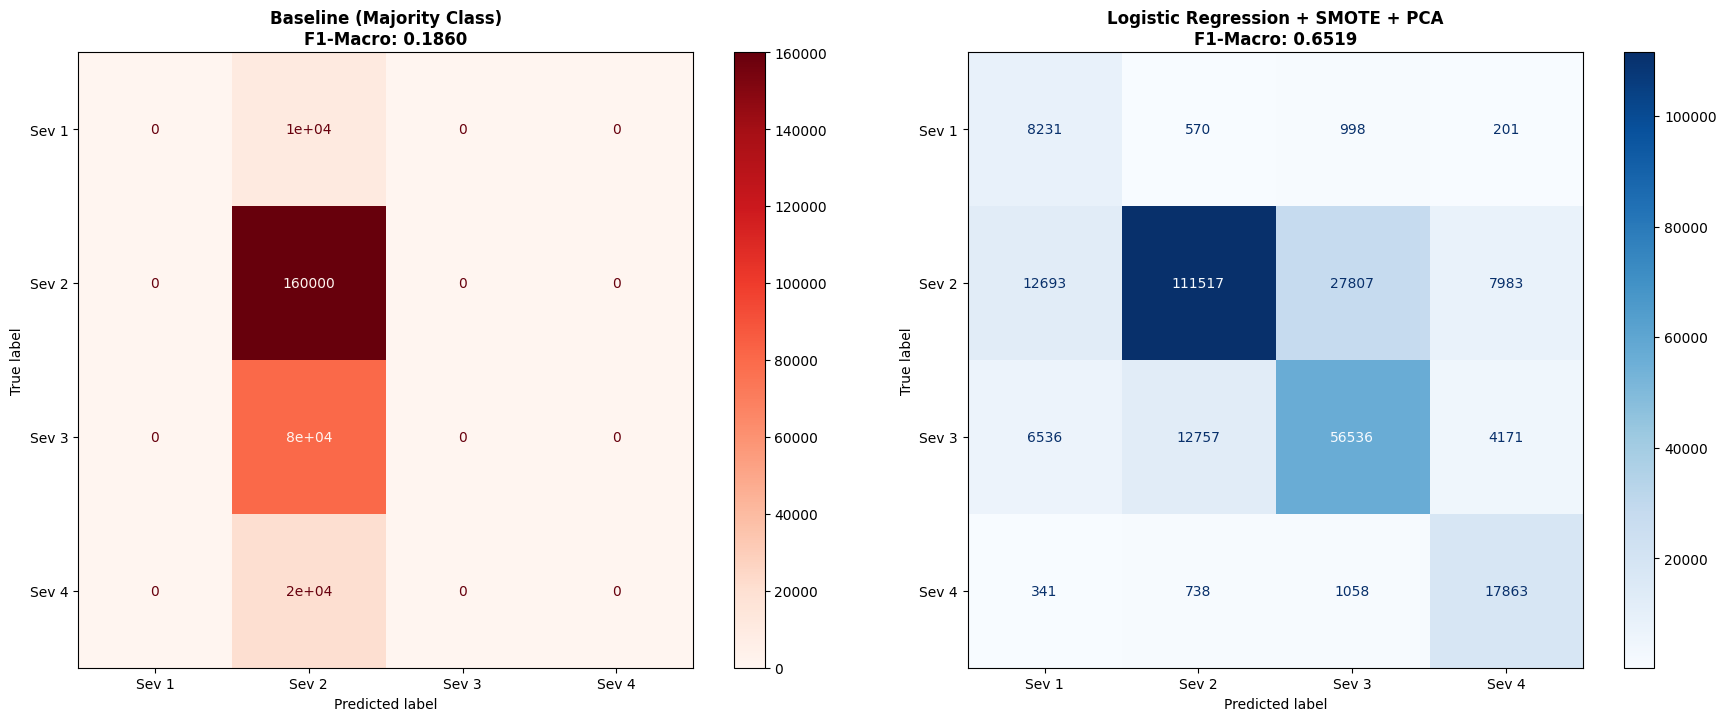

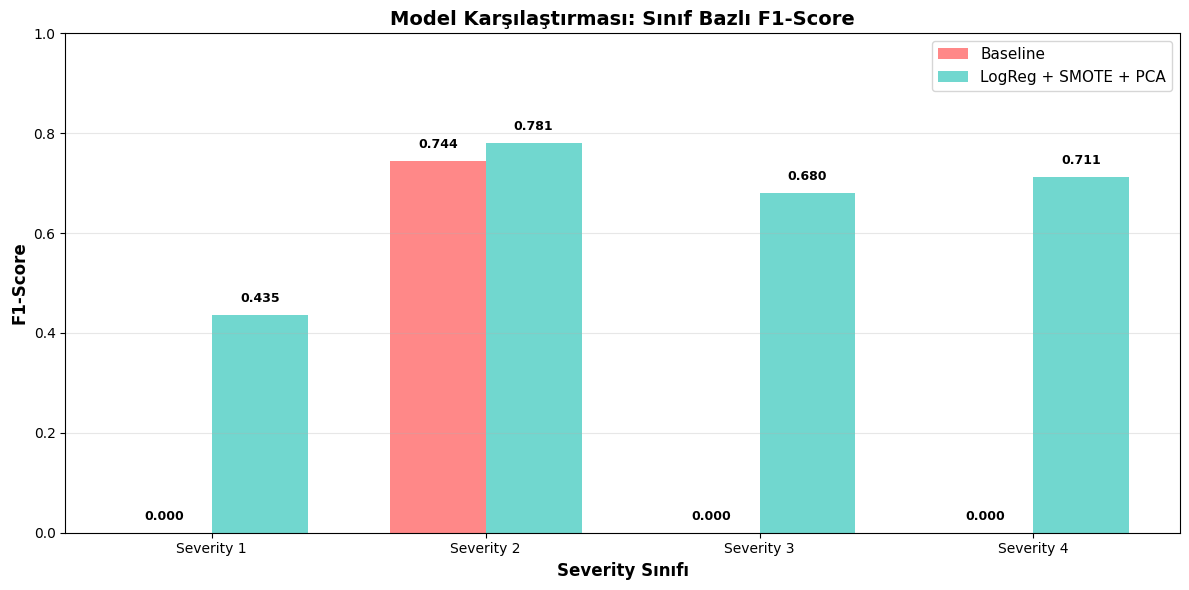

In [12]:
# ======================================================================================
# --- BÖLÜM 11: DETAYLI RAPOR VE GÖRSELLEŞTİRME ---
# ======================================================================================
print("\n\n############################################################")
print("### BÖLÜM 11: DETAYLI RAPOR VE GÖRSELLEŞTİRME ###")
print("############################################################\n")

print("--- Classification Report (Logistic Regression + SMOTE + PCA) ---")
print(classification_report(y_test_adjusted, y_pred, target_names=severity_names))

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Baseline CM
cm_baseline = confusion_matrix(y_test_adjusted, y_pred_baseline)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
disp1.plot(cmap=plt.cm.Reds, ax=axes[0])
axes[0].set_title(f'Baseline (Majority Class)\nF1-Macro: {baseline_f1_macro:.4f}', fontsize=12, fontweight='bold')

# Actual CM
cm = confusion_matrix(y_test_adjusted, y_pred)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
disp2.plot(cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title(f'Logistic Regression + SMOTE + PCA\nF1-Macro: {test_f1_macro:.4f}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Sınıf bazlı F1-Score grafiği
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(severity_names))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_f1_per_class, width, label='Baseline', alpha=0.8, color='#FF6B6B')
bars2 = ax.bar(x + width/2, test_f1_per_class, width, label='LogReg + SMOTE + PCA', alpha=0.8, color='#4ECDC4')

ax.set_xlabel('Severity Sınıfı', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Model Karşılaştırması: Sınıf Bazlı F1-Score', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(severity_names)
ax.legend(fontsize=11)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Her bar üzerine değer yaz
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()


###  Bölüm 11: Görselleştirme ve Sonuç Analizi

Bu bölümde model performansı üç farklı açıdan görselleştirilmiştir:

1.  **Sınıflandırma Raporu (Metin):** Her bir sınıf için `Precision` (Kesinlik), `Recall` (Duyarlılık) ve `F1-Score` değerlerinin detaylı dökümü.
2.  **Karmaşıklık Matrisleri (Confusion Matrix):**
    *   **Sol (Kırmızı - Baseline):** Referans modelin davranışı. Genellikle tüm tahminlerin tek bir dikey sütunda (en sık görülen sınıf) toplandığı görülür. Bu, modelin öğrenmediğinin kanıtıdır.
    *   **Sağ (Mavi - Actual):** Geliştirilen modelin davranışı. İdeal bir modelde, yoğunluğun sol-üstten sağ-alta doğru uzanan **köşegen (diagonal)** üzerinde toplanması beklenir. Köşegen dışındaki sayılar hatalı tahminleri gösterir.
3.  **Sınıf Bazlı F1 Karşılaştırması (Çubuk Grafik):**
    *   Hangi sınıflarda iyileşme sağlandığını net bir şekilde gösterir. Özellikle SMOTE kullanımı sayesinde, Baseline modelin hiç tahmin edemediği (Skoru 0 olan) azınlık sınıflarında, yeni modelin çubuklarının yükselmesi başarının en büyük göstergesidir.


############################################################
### BÖLÜM 12: DETAYLI HATA ANALİZİ ###
############################################################

📊 DETAYLI SINIF BAZLI METRJKLER:

Severity 1:
   Precision: 0.2961
   Recall: 0.8231
   F1-Score: 0.4355

Severity 2:
   Precision: 0.8880
   Recall: 0.6970
   F1-Score: 0.7810

Severity 3:
   Precision: 0.6544
   Recall: 0.7067
   F1-Score: 0.6795

Severity 4:
   Precision: 0.5911
   Recall: 0.8931
   F1-Score: 0.7114



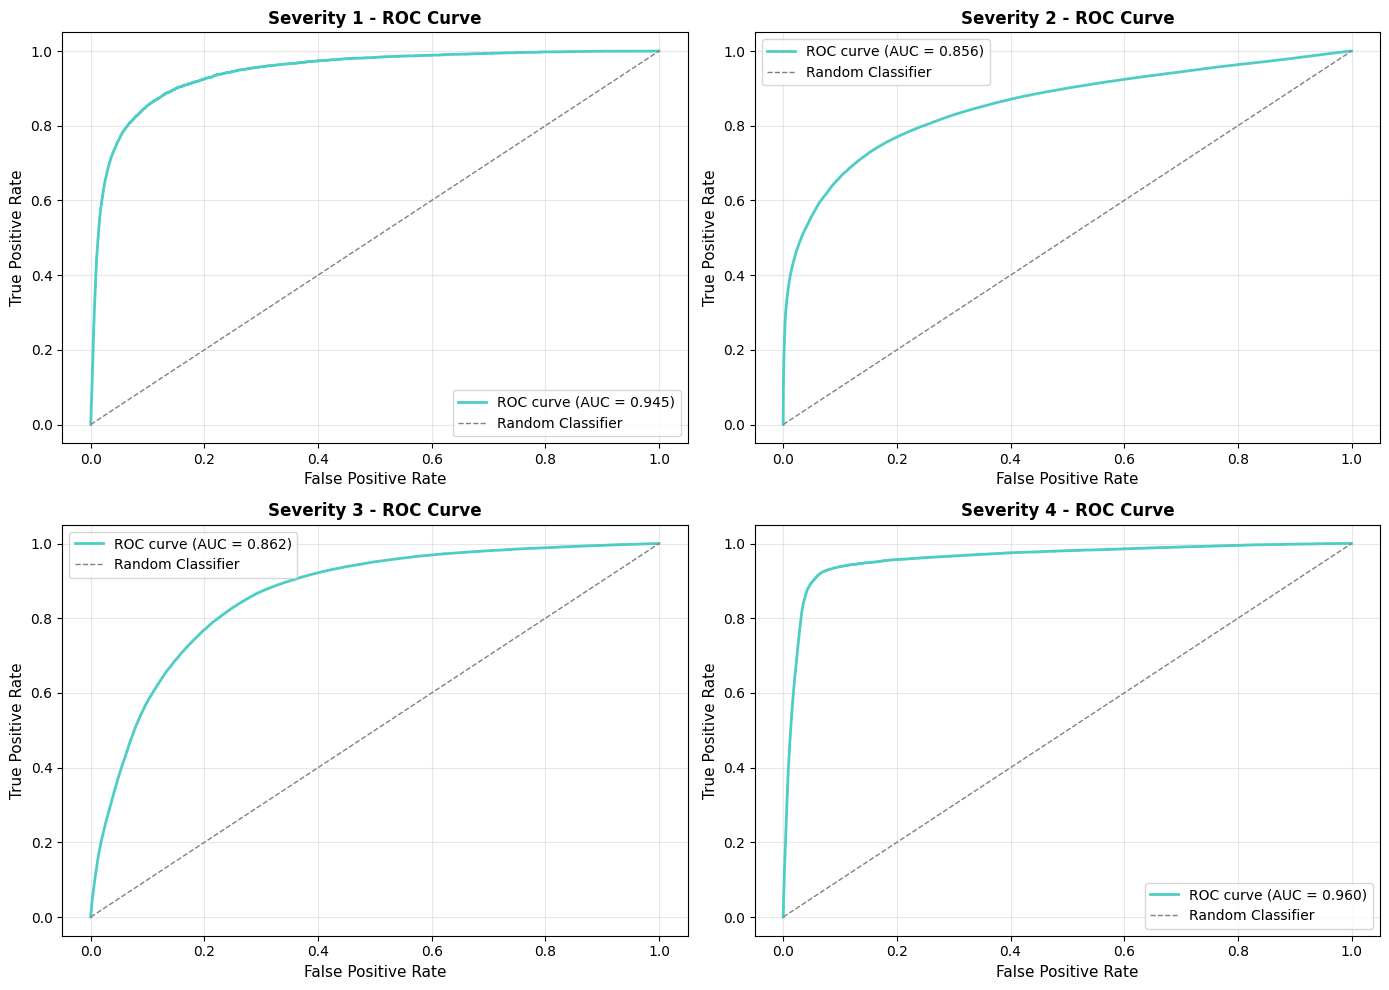

In [13]:
# ======================================================================================
# --- BÖLÜM 12: DETAYLI HATA ANALİZİ (PER-CLASS METRICS) ---
# ======================================================================================
print("\n############################################################")
print("### BÖLÜM 12: DETAYLI HATA ANALİZİ ###")
print("############################################################\n")

from sklearn.metrics import precision_score, recall_score

print("📊 DETAYLI SINIF BAZLI METRJKLER:\n")

for i, name in enumerate(severity_names):
    # One-vs-Rest yaklaşımı
    y_test_binary = (y_test_adjusted == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)
    
    precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_test_binary, y_pred_binary, zero_division=0)
    
    print(f"{name}:")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print()

# ROC-AUC grafiği (One-vs-Rest)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, name in enumerate(severity_names):
    y_test_binary = (y_test_adjusted == i).astype(int)
    
    # OvR için probability
    y_score = y_pred_proba[:, i]
    
    fpr, tpr, _ = roc_curve(y_test_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    axes[i].plot(fpr, tpr, color='#4ECDC4', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[i].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
    axes[i].set_xlabel('False Positive Rate', fontsize=11)
    axes[i].set_ylabel('True Positive Rate', fontsize=11)
    axes[i].set_title(f'{name} - ROC Curve', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



###  Bölüm 12: Detaylı Hata Analizi ve ROC Eğrileri

Modelin performansını yüzeysel olarak değil, sınıf bazında derinlemesine incelediğimiz bölümdür.

**Analiz Kriterleri:**
1.  **Precision vs Recall:**
    *   **Precision (Kesinlik):** Model "Severity 2" dediğinde ne kadar haklı? (Yanlış alarm oranı).
    *   **Recall (Duyarlılık):** Gerçekteki "Severity 2" kazalarının kaçını yakalayabildi? (Gözden kaçırma oranı).
2.  **ROC Eğrisi ve AUC:**
    *   Modelin olasılık tahminlerinin kalitesini ölçer.
    *   **İdeal Senaryo:** Eğrinin sol üst köşeye yapışık olması (AUC = 1.0).
    *   **Kötü Senaryo:** Eğrinin çapraz gri çizgi üzerinde olması (AUC = 0.5, yazı-tura atmakla eşdeğer).
    *   Her bir sınıf için ayrı ayrı çizdirilmesinin sebebi, modelin hangi sınıfta zorlandığını (örn. az veri olan Severity 1) görsel olarak tespit etmektir.


############################################################
### BÖLÜM 13: PCA ANALİZİ ###
############################################################

📊 PCA İstatistikleri:
   - Orijinal özellik sayısı: 108
   - PCA sonrası bileşen sayısı: 90
   - Açıklanan toplam varyans: %95.33
   - Boyut indirgeme oranı: %16.67


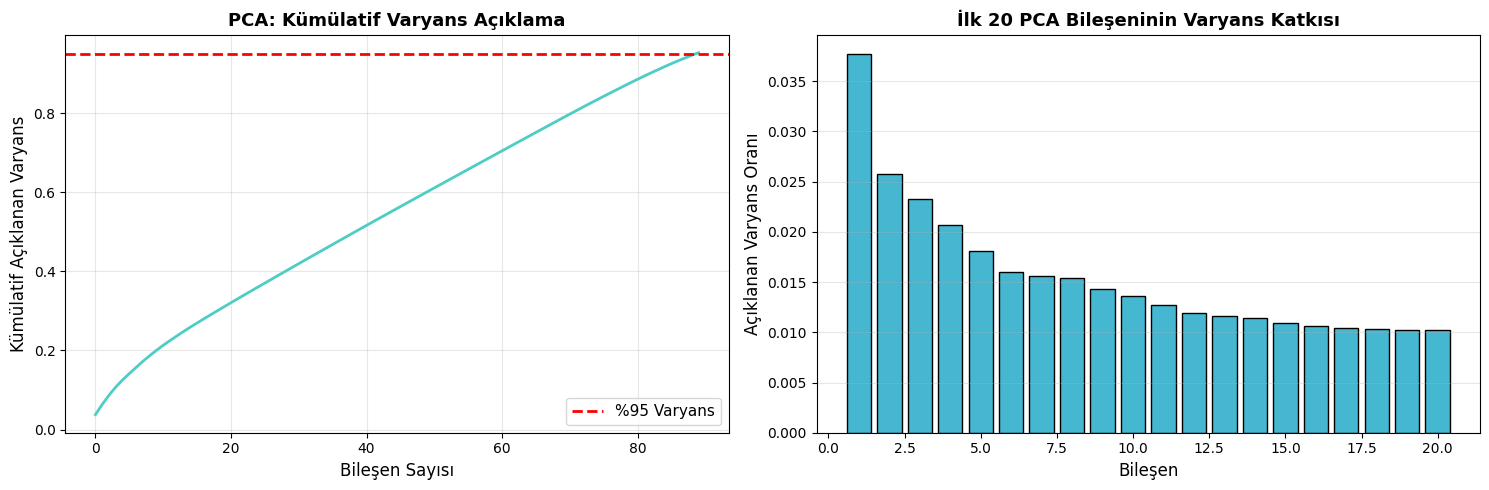

In [14]:
# ======================================================================================
# --- BÖLÜM 13: PCA ANALİZİ ---
# ======================================================================================
print("\n############################################################")
print("### BÖLÜM 13: PCA ANALİZİ ###")
print("############################################################\n")

pca_component = best_model.named_steps['pca']

print(f"📊 PCA İstatistikleri:")
print(f"   - Orijinal özellik sayısı: {X_train_final.shape[1]}")
print(f"   - PCA sonrası bileşen sayısı: {pca_component.n_components_}")
print(f"   - Açıklanan toplam varyans: %{pca_component.explained_variance_ratio_.sum()*100:.2f}")
print(f"   - Boyut indirgeme oranı: %{(1 - pca_component.n_components_/X_train_final.shape[1])*100:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(np.cumsum(pca_component.explained_variance_ratio_), linewidth=2, color='#4ECDC4')
axes[0].set_xlabel('Bileşen Sayısı', fontsize=12)
axes[0].set_ylabel('Kümülatif Açıklanan Varyans', fontsize=12)
axes[0].set_title('PCA: Kümülatif Varyans Açıklama', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='%95 Varyans')
axes[0].legend(fontsize=11)

n_show = min(20, len(pca_component.explained_variance_ratio_))
axes[1].bar(range(1, n_show+1), pca_component.explained_variance_ratio_[:n_show], 
            color='#45B7D1', edgecolor='black', linewidth=1)
axes[1].set_xlabel('Bileşen', fontsize=12)
axes[1].set_ylabel('Açıklanan Varyans Oranı', fontsize=12)
axes[1].set_title(f'İlk {n_show} PCA Bileşeninin Varyans Katkısı', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


###  Bölüm 13: Boyut İndirgeme (PCA) Performansı

Modelin eğitim süresini hızlandırmak ve gürültüyü azaltmak için uygulanan PCA işleminin sonuçları incelenmektedir.

**Analiz Sonuçları:**
*   **Sıkıştırma Oranı:** Orijinal özellik sayısı ile PCA sonrası kalan bileşen sayısı kıyaslanarak, verinin ne kadar küçültüldüğü hesaplanır.
*   **Bilgi Kaybı:** Hedeflenen %95 varyans (bilgi) korunurken, gereksiz özelliklerin yüzde kaçının atıldığı görülür.
*   **Grafik Yorumu:**
    *   **Soldaki Grafik:** Kümülatif varyansı gösterir. Eğri ne kadar dik yükseliyorsa, ilk birkaç bileşen o kadar çok bilgi taşıyor demektir. Kırmızı çizgi (%95) hedefe ulaşılan noktadır.
    *   **Sağdaki Grafik:** İlk bileşenlerin tek tek ne kadar bilgi taşıdığını gösterir. Genellikle ilk 3-5 bileşen en büyük yükü taşır.

In [16]:
# ======================================================================================
# --- FİNAL ÖZET RAPORU ---
# ======================================================================================
print("\n\n" + "="*100)
print("###  FİNAL ÖZET RAPORU 🎉 ###")
print("="*100)

print(f"\n VERİ SETİ BOYUTU:")
print(f"   - Toplam Örneklem: {len(df_sample):,}")
print(f"   - Eğitim Seti: {len(X_train):,}")
print(f"   - Test Seti: {len(X_test):,}")
print(f"   - Orijinal Özellik Sayısı: {X_train_final.shape[1]}")
print(f"   - PCA Sonrası Bileşen: {pca_component.n_components_}")

print(f"\n BAŞARILI MODEL: Logistic Regression + SMOTE + PCA")
print(f"   - Test F1-Macro Score: {test_f1_macro:.4f}")
print(f"   - CV F1-Macro Score: {grid_search.best_score_:.4f}")
print(f"   - Baseline Karşılaştırması: {((test_f1_macro - baseline_f1_macro) / baseline_f1_macro * 100):.2f}% iyileşme")
print(f"   - Eğitim Süresi: {end_time - start_time:.2f} saniye")

print(f"\n SINIF BAZLI F1-SCORE:")
for name, score in zip(severity_names, test_f1_per_class):
    print(f"   {name}: {score:.4f}")

print(f"\n  EN İYİ HİPERPARAMETRELER:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print("\n" + "="*100)
print("###  TAMAMLANDI! ###")
print("="*100)




###  FİNAL ÖZET RAPORU 🎉 ###

 VERİ SETİ BOYUTU:
   - Toplam Örneklem: 1,350,000
   - Eğitim Seti: 1,080,000
   - Test Seti: 270,000
   - Orijinal Özellik Sayısı: 108
   - PCA Sonrası Bileşen: 90

 BAŞARILI MODEL: Logistic Regression + SMOTE + PCA
   - Test F1-Macro Score: 0.6519
   - CV F1-Macro Score: 0.6525
   - Baseline Karşılaştırması: 250.37% iyileşme
   - Eğitim Süresi: 667.89 saniye

 SINIF BAZLI F1-SCORE:
   Severity 1: 0.4355
   Severity 2: 0.7810
   Severity 3: 0.6795
   Severity 4: 0.7114

  EN İYİ HİPERPARAMETRELER:
   clf__C: 1
   clf__solver: lbfgs
   pca__n_components: 0.95

###  TAMAMLANDI! ###


###  Final Raporu ve Proje Özeti

Bu son blok, tüm deneyin sonuçlarını konsolide ederek okunabilir bir "kapanış raporu" üretir. Projenin başarısını kanıtlamak için gereken tüm kritik veriler burada özetlenmiştir:

*   **Veri Dönüşümü:** Ham veriden PCA ile sıkıştırılmış veriye geçişin boyut analizi.
*   **Net Başarı:** Baseline modele kıyasla sağlanan yüzdesel iyileşme (Projenin katma değeri).
*   **Model Kimliği:** Gelecekte bu modeli tekrar kurmak (reproduce) için gerekli olan "En İyi Hiperparametreler" listesi.
*   **Süreç:** Eğitim süresi ve kullanılan toplam veri miktarı.